# Sex Differences in Functional Gradients - Sex Classification GSP & HCP

## Load packages

In [1]:
# General
import os
import sys
import numpy as np
import pandas as pd
import csv
from math import isnan

# Computing
import scipy.io  # loadmat
from scipy import stats
import sklearn 
from brainstat.stats.terms import FixedEffect
from brainstat.stats.SLM import SLM

# Visualisation
import matplotlib.pyplot as plt 
import seaborn as sns
import vtk
from IPython.display import display
import matplotlib.collections as clt
import ptitprince as pt

# Neuroimaging
import nibabel
import nilearn
from brainstat.datasets import fetch_parcellation
from enigmatoolbox.permutation_testing import spin_test, shuf_test

# Gradients
import brainspace
from brainspace.datasets import load_parcellation, load_conte69
from brainspace.plotting import plot_hemispheres
from brainspace.gradient import GradientMaps
from brainspace.utils.parcellation import map_to_labels

## Define directories

In [43]:
codedir = os.path.abspath('')  # obtain current direction from which script is runnning

datadir = '/data/p_02667/sex_diff_gradients/data/'

resdir = '/data/p_02667/sex_diff_gradients/results/'

## Set-up

### Fetch fsaverage parcellation (coded for Schaefer 400 parcels) - for Spin permutation tests

Spin permutation testing: https://enigma-toolbox.readthedocs.io/en/latest/pages/08.spintest/index.html

In [22]:
# fetch the fsaverage parcellation indicating which schafer parcel (1-400) each of fsaverage5's 20484 vertices belong to
schaefer_400_fs5 = fetch_parcellation("fsaverage5", "schaefer", 400)

### Import the Yeo 7 network coding for the Schaefer 400 parcellation scheme - for plotting by Yeo network (color)

In [44]:
# labels: 1=visual, 2=sensory motor, 3=dorsal attention, 4=ventral attention, 5=limbic, 6=fronto parietal, 7= DMN

with open(datadir+'yeo_7.csv') as f:
    reader = csv.reader(f)
    yeo7_networks = list(reader)[0]  # need [0] because the network values are contained in double brackets [[ ]]

In [46]:
# making an array with yeo network labels (names instead of numbers)
yeo7_networks_array_labels = []

for i in yeo7_networks:
    if i == '1':
        yeo7_networks_array_labels.append('visual')
    elif i == '2':
        yeo7_networks_array_labels.append('sensory motor')
    elif i == '3':
        yeo7_networks_array_labels.append('dorsal attention')
    elif i == '4':
        yeo7_networks_array_labels.append('ventral attention')
    elif i == '5':
        yeo7_networks_array_labels.append('limbic')
    elif i == '6':
        yeo7_networks_array_labels.append('fronto parietal')
    elif i == '7':
        yeo7_networks_array_labels.append('DMN')

yeo7_networks_array_labels = np.asarray(yeo7_networks_array_labels)


# dictionary color palette emphasizing visual, sensory motor, and DMN networks
palette_visual_sensmotor_DMN = {"visual":"tab:cyan",
                                "sensory motor":"tab:orange", 
                                "DMN":"tab:purple",
                                
                                "dorsal attention":"tab:grey",
                                "ventral attention":"tab:grey",
                                "limbic":"tab:grey",
                                "fronto parietal":"tab:grey"}

In [104]:
network_labels = ['visual', 'sensory motor', 'dorsal attention', 'ventral attention', 'limbic', 'fronto parietal', 'DMN']

### Definitions

In [162]:
def print_plot_corr_networks(df1, df2, var, x_label, y_label):
    
    '''
    
    
    Output:
    - correlations between 2 columns of a dataframe, both overall and per network
    - scatterplots colorcoded by yeo network, with regression lines per network
    
    
    '''
    
    # creating a dataframe in order to have the data in the correct format to be plotted
    temp_dict = {x_label: df1[var], y_label: df2[var], 'yeo_network': yeo7_networks_array_labels}  
    dataframe = pd.DataFrame(data = temp_dict)
    

    
    network_labels = ['visual', 'sensory motor', 'dorsal attention', 'ventral attention', 'limbic', 'fronto parietal', 'DMN']

    for i in range(len(network_labels)):
        
        corr_coef = stats.pearsonr(dataframe.loc[dataframe['yeo_network'] == network_labels[i]][x_label], dataframe.loc[dataframe['yeo_network'] == network_labels[i]][y_label])[0]
        p_val = stats.pearsonr(dataframe.loc[dataframe['yeo_network'] == network_labels[i]][x_label], dataframe.loc[dataframe['yeo_network'] == network_labels[i]][y_label])[1]
        
        print(f"{network_labels[i]}: r = {corr_coef}, p = {round(p_val, 3)}")
        
    
    # scatter plot color-coded by network, with regression lines 
    
    sns.lmplot(x = x_label, y = y_label, 
           hue = 'yeo_network',
           data = dataframe,
           ci = False)

    sns.despine()

    plt.title(f'Overall Pearson correlation: r = {round(stats.pearsonr(dataframe[x_label], dataframe[y_label])[0],2)}; p = {round(stats.pearsonr(dataframe[x_label], dataframe[y_label])[1],2)}')
    plt.xlabel(x_label)
    plt.ylabel(y_label)

#### other types of plots 

In [89]:
dict_to_plot = {'GSP_G2_t_val': GSP_slm_G2.t_val_sex, 'HCP_G1_t_val': HCP_slm_G1.t_val_sex, 'yeo_network': yeo7_networks_array_labels}
df_tval_sex_diff = pd.DataFrame(data = dict_to_plot)

In [110]:
df_tval_sex_diff

,GSP_G2_t_val,HCP_G1_t_val,yeo_network
0,1.780672,-1.635570,visual
1,0.216287,-4.805591,visual
2,2.305462,2.263515,visual
3,2.286735,2.268279,visual
4,2.985627,2.618321,visual
...,...,...,...
395,-4.240799,-5.380172,DMN
396,-2.923256,-3.316582,DMN
397,-2.323046,-1.077513,DMN
398,-3.617870,-3.277685,DMN


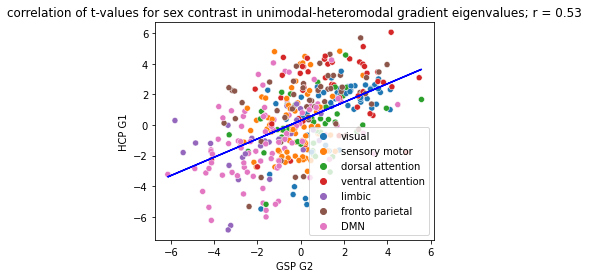

In [ ]:
def line(x,y):
    
    """Fit a line in a scatter 
    based on slope and intercept"""
    
    slope, intercept = np.polyfit(x, y, 1)
    line_values = [slope * i + intercept for i in x]
    plt.plot(x, line_values, 'b')


fig, ax = plt.subplots(1, figsize=(5, 4))

sns.scatterplot(GSP_slm_G2.t_val_sex, HCP_slm_G1.t_val_sex, 
                hue = yeo7_networks_array_labels)

ax.set_title(f'correlation of t-values for sex contrast in unimodal-heteromodal gradient eigenvalues; r = {round(stats.pearsonr(GSP_slm_G2.t_val_sex, HCP_slm_G1.t_val_sex)[0],2)}')
ax.set_xlabel('GSP G2')
ax.set_ylabel('HCP G1')
line(GSP_slm_G2.t_val_sex, HCP_slm_G1.t_val_sex)

## Comparing results between GSP and HCP samples for 3 fc gradients

In [199]:
## loading mean gradient arrays

# GSP
GSP_mean_grad = pd.read_csv(resdir+'GSP/mean_gradient_eigenvalues.csv')

# labeling the gradients whereby for GSP: unimodal-heteromodal (G2), visual-sensorimotor (G1)
GSP_mean_grad.columns = ['visual-sensorimotor', 'unimodal-heteromodal', 'G3', 'G4', 'G5', 'G6', 'G7', 'G8', 'G9', 'G10']


# HCP
HCP_mean_grad = pd.read_csv(resdir+'HCP/mean_gradient_eigenvalues.csv')  

# labeling the gradients whereby for HCP: unimodal-heteromodal (G1), visual-sensorimotor (G2)
HCP_mean_grad.columns = ['unimodal-heteromodal', 'visual-sensorimotor', 'G3', 'G4', 'G5', 'G6', 'G7', 'G8', 'G9', 'G10']


## loading SLM (model including sex, age and ICV for sex testing for sex differences) containing R results

# GSP
GSP_slm_G1 = pd.read_csv(resdir+'GSP/R_lm_G1_sex_age_icv_res.csv')  # visual - somatomotor
GSP_slm_G2 = pd.read_csv(resdir+'GSP/R_lm_G2_sex_age_icv_res.csv')  # unimodal - heteromodal
GSP_slm_G3 = pd.read_csv(resdir+'GSP/R_lm_G3_sex_age_icv_res.csv')  

# HCP
HCP_slm_G1 = pd.read_csv(resdir+'HCP/R_lm_G1_sex_age_icv_res.csv')  # unimodal - heteromodal
HCP_slm_G2 = pd.read_csv(resdir+'HCP/R_lm_G2_sex_age_icv_res.csv')  # visual - somatomotor
HCP_slm_G3 = pd.read_csv(resdir+'HCP/R_lm_G3_sex_age_icv_res.csv')  

### Correlation of mean gradients: all

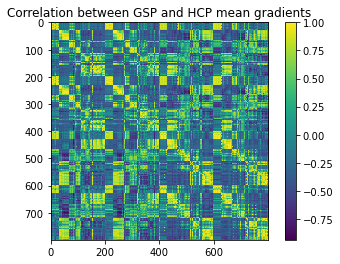

(800, 800)


In [32]:
GSP_HCP_eigenvalues_corr = np.corrcoef(np.array(GSP_mean_grad), np.array(HCP_mean_grad))

# data
fig, ax = plt.subplots()
heatmap = ax.pcolor(GSP_HCP_eigenvalues_corr)
# legend
cbar = plt.colorbar(heatmap)
plt.imshow(np.corrcoef(GSP_HCP_eigenvalues_corr))
plt.title('Correlation between GSP and HCP mean gradients', fontdict=None, loc='center', pad=None)
plt.show()
print(GSP_HCP_eigenvalues_corr.shape)

### Correlation of mean gradients: Unimodal-Heteromodal

In [165]:
stats.pearsonr(GSP_mean_grad.loc[:,'unimodal-heteromodal'], HCP_mean_grad.loc[:,'unimodal-heteromodal'])

(0.9090968593615992, 1.9268649390890472e-153)

visual: r = 0.868167367471474, p = 0.0
sensory motor: r = 0.14896103002392624, p = 0.196
dorsal attention: r = 0.22952076778031935, p = 0.125
ventral attention: r = 0.5715658945438941, p = 0.0
limbic: r = 0.8250837958378611, p = 0.0
fronto parietal: r = 0.6379206268147818, p = 0.0
DMN: r = 0.7757328159618283, p = 0.0


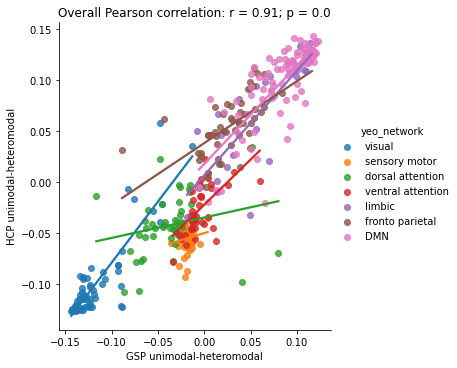

In [174]:
print_plot_corr_networks(df1 = GSP_mean_grad, df2 = HCP_mean_grad, var = 'unimodal-heteromodal', x_label = 'GSP unimodal-heteromodal', y_label = 'HCP unimodal-heteromodal')

Text(0, 0.5, 'HCP G1')

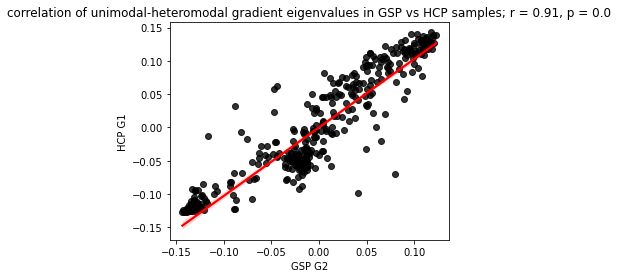

In [180]:
fig, ax = plt.subplots(1, figsize=(5, 4))

sns.regplot(x = GSP_mean_grad.loc[:,'unimodal-heteromodal'], y = HCP_mean_grad.loc[:,'unimodal-heteromodal'],
            scatter_kws={"color": "black"}, line_kws={"color": "red"})

temp_corr = stats.pearsonr(GSP_mean_grad.loc[:,'unimodal-heteromodal'], HCP_mean_grad.loc[:,'unimodal-heteromodal'])

ax.set_title(f'correlation of unimodal-heteromodal gradient eigenvalues in GSP vs HCP samples; r = {round(temp_corr[0],2)}, p = {round(temp_corr[1],3)}')

ax.set_xlabel('GSP G2')
ax.set_ylabel('HCP G1')


#### Spin permutation test

Project unimodal-heteromodal gradient eigenvalues (from Schaefer 400 parcellation) to fsaverage5's 20484 vertices

In [195]:
GSP_fs5_eigenvalues_unimodal_heteromodal = []
HCP_fs5_eigenvalues_unimodal_heteromoda1 = []

# iterate over the 20484 vertices in fsaverage5
for i in range(len(schaefer_400_fs5)):
    
    #if schaefer_400_fs5[i] == 'nan'
    if schaefer_400_fs5[i] == 0:
        # append to the lists of fs5_tvals: 0
        GSP_fs5_eigenvalues_unimodal_heteromodal.append(0)
        HCP_fs5_eigenvalues_unimodal_heteromoda1.append(0)
        
    # if schaefer_400_fs5 has a value
    else:
        # append to the lists of fs5_tvals: the unimodal-heteromodal gradient eigenvalue of the corresponding Schaefer parcel (here parcel value [i] - 1 because parcel numbers go from 1-400 instead of 0-399 as required for indexing)
        GSP_fs5_eigenvalues_unimodal_heteromodal.append(GSP_mean_grad.loc[:, 'unimodal-heteromodal'][schaefer_400_fs5[i]-1])
        HCP_fs5_eigenvalues_unimodal_heteromoda1.append(HCP_mean_grad.loc[:, 'unimodal-heteromodal'][schaefer_400_fs5[i]-1])

# change the zeros into nan (couldn't nan directly because then it made the array content strings
GSP_fs5_eigenvalues_unimodal_heteromodal[GSP_fs5_eigenvalues_unimodal_heteromodal == 0] = np.nan
HCP_fs5_eigenvalues_unimodal_heteromoda1[HCP_fs5_eigenvalues_unimodal_heteromoda1 == 0] = np.nan

# transform list into array
GSP_fs5_eigenvalues_unimodal_heteromodal = np.asarray(GSP_fs5_eigenvalues_unimodal_heteromodal)
HCP_fs5_eigenvalues_unimodal_heteromoda1 = np.asarray(HCP_fs5_eigenvalues_unimodal_heteromoda1)

Spin permutation

In [196]:
# Spin permutation testing for two cortical maps (output of spin_test is the p-value and the null distribution)
spin_test_p, spin_test_d = spin_test(GSP_fs5_eigenvalues_unimodal_heteromodal, HCP_fs5_eigenvalues_unimodal_heteromoda1, surface_name='fsa5', parcellation_name='aparc', type='pearson', n_rot=1000, null_dist=True)

permutation 100 of 1000
permutation 200 of 1000
permutation 300 of 1000
permutation 400 of 1000
permutation 500 of 1000
permutation 600 of 1000
permutation 700 of 1000
permutation 800 of 1000
permutation 900 of 1000
permutation 1000 of 1000


In [197]:
spin_test_p

0.001

To better interpret statistical significance, we can plot the null distribution of generated correlations (i.e., “spun” or “shuffled” correlations) and overlay the correlation coefficient obtained from the empirical (i.e., real) brain maps.

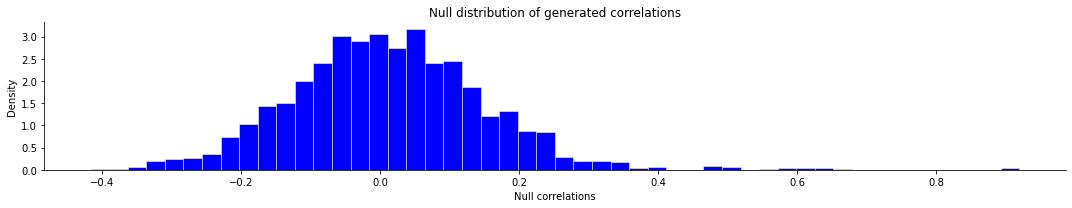

In [198]:
fig, ax = plt.subplots(1, figsize=(15, 3))

ax.hist(spin_test_d, bins=50, density=True, color="blue", edgecolor='white', lw=0.5)
ax.set_xlabel('Null correlations')
ax.set_ylabel('Density')
ax.set_title('Null distribution of generated correlations')
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

    
fig.tight_layout()
plt.show()

### Correlation of mean gradients: visual-sensorimotor

In [201]:
stats.pearsonr(GSP_mean_grad.loc[:,'visual-sensorimotor'], HCP_mean_grad.loc[:,'visual-sensorimotor'])

(0.9128765076669858, 6.077381262313307e-157)

visual: r = 0.8657777927423497, p = 0.0
sensory motor: r = 0.23902667172902686, p = 0.036
dorsal attention: r = 0.7114429228491049, p = 0.0
ventral attention: r = 0.8042183509406081, p = 0.0
limbic: r = 0.4137828292543885, p = 0.036
fronto parietal: r = 0.5241842305359979, p = 0.0
DMN: r = 0.9273777673590986, p = 0.0


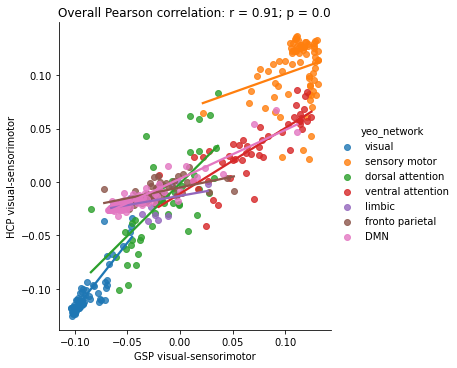

In [200]:
print_plot_corr_networks(df1 = GSP_mean_grad, df2 = HCP_mean_grad, var = 'visual-sensorimotor', x_label = 'GSP visual-sensorimotor', y_label = 'HCP visual-sensorimotor')

Text(0, 0.5, 'HCP G1')

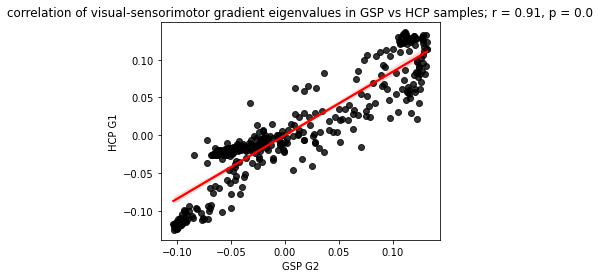

In [202]:
fig, ax = plt.subplots(1, figsize=(5, 4))

sns.regplot(x = GSP_mean_grad.loc[:,'visual-sensorimotor'], y = HCP_mean_grad.loc[:,'visual-sensorimotor'],
            scatter_kws={"color": "black"}, line_kws={"color": "red"})

temp_corr = stats.pearsonr(GSP_mean_grad.loc[:,'visual-sensorimotor'], HCP_mean_grad.loc[:,'visual-sensorimotor'])

ax.set_title(f'correlation of visual-sensorimotor gradient eigenvalues in GSP vs HCP samples; r = {round(temp_corr[0],2)}, p = {round(temp_corr[1],3)}')

ax.set_xlabel('GSP G2')
ax.set_ylabel('HCP G1')


#### Spin permutation test

Project unimodal-heteromodal gradient eigenvalues (from Schaefer 400 parcellation) to fsaverage5's 20484 vertices

In [191]:
GSP_fs5_eigenvalues_visual_sensorimotor = []
HCP_fs5_eigenvalues_visual_sensorimotor = []

# iterate over the 20484 vertices in fsaverage5
for i in range(len(schaefer_400_fs5)):
    
    #if schaefer_400_fs5[i] == 'nan'
    if schaefer_400_fs5[i] == 0:
        # append to the lists of fs5_tvals: 0
        GSP_fs5_eigenvalues_visual_sensorimotor.append(0)
        HCP_fs5_eigenvalues_visual_sensorimotor.append(0)
        
    # if schaefer_400_fs5 has a value
    else:
        # append to the lists of fs5_tvals: the unimodal-heteromodal gradient eigenvalue of the corresponding Schaefer parcel (here parcel value [i] - 1 because parcel numbers go from 1-400 instead of 0-399 as required for indexing)
        GSP_fs5_eigenvalues_visual_sensorimotor.append(GSP_mean_grad.loc[:, 'visual-sensorimotor'][schaefer_400_fs5[i]-1])
        HCP_fs5_eigenvalues_visual_sensorimotor.append(HCP_mean_grad.loc[:, 'visual-sensorimotor'][schaefer_400_fs5[i]-1])

# change the zeros into nan (couldn't nan directly because then it made the array content strings
GSP_fs5_eigenvalues_visual_sensorimotor[GSP_fs5_eigenvalues_visual_sensorimotor == 0] = np.nan
HCP_fs5_eigenvalues_visual_sensorimotor[HCP_fs5_eigenvalues_visual_sensorimotor == 0] = np.nan

# transform list into array
GSP_fs5_eigenvalues_visual_sensorimotor = np.asarray(GSP_fs5_eigenvalues_visual_sensorimotor)
HCP_fs5_eigenvalues_visual_sensorimotor = np.asarray(HCP_fs5_eigenvalues_visual_sensorimotor)

#### Spin permutation test

Project unimodal-heteromodal gradient eigenvalues (from Schaefer 400 parcellation) to fsaverage5's 20484 vertices

Spin permutation

In [192]:
# Spin permutation testing for two cortical maps (output of spin_test is the p-value and the null distribution)
spin_test_p, spin_test_d = spin_test(GSP_fs5_eigenvalues_visual_sensorimotor, HCP_fs5_eigenvalues_visual_sensorimotor, surface_name='fsa5', parcellation_name='aparc', type='pearson', n_rot=1000, null_dist=True)

permutation 100 of 1000
permutation 200 of 1000
permutation 300 of 1000
permutation 400 of 1000
permutation 500 of 1000
permutation 600 of 1000
permutation 700 of 1000
permutation 800 of 1000
permutation 900 of 1000
permutation 1000 of 1000


In [193]:
spin_test_p

0.002

To better interpret statistical significance, we can plot the null distribution of generated correlations (i.e., “spun” or “shuffled” correlations) and overlay the correlation coefficient obtained from the empirical (i.e., real) brain maps.

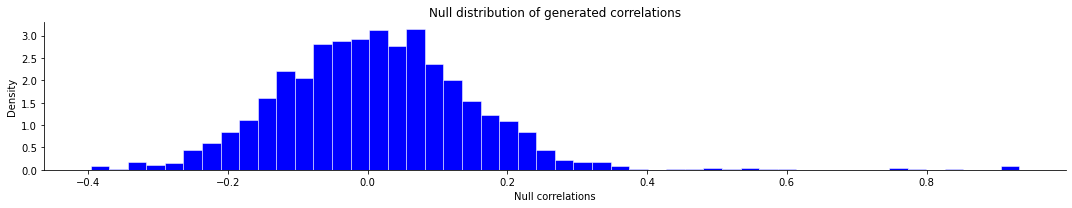

In [194]:
fig, ax = plt.subplots(1, figsize=(15, 3))

ax.hist(spin_test_d, bins=50, density=True, color="blue", edgecolor='white', lw=0.5)
ax.set_xlabel('Null correlations')
ax.set_ylabel('Density')
ax.set_title('Null distribution of generated correlations')
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

    
fig.tight_layout()
plt.show()

### Correlation of t-values

In [23]:
stats.pearsonr(GSP_slm_G2.t_val_sex, HCP_slm_G1.t_val_sex)

(0.5254135056001684, 9.105665887477931e-30)

visual: r = 0.5836581160375119, p = 0.0
sensory motor: r = 0.2271159518226633, p = 0.047
dorsal attention: r = 0.3410166754731129, p = 0.02
ventral attention: r = 0.3260271164060725, p = 0.025
limbic: r = 0.37781446185566936, p = 0.057
fronto parietal: r = 0.40325352243023094, p = 0.003
DMN: r = 0.43433856244285096, p = 0.0


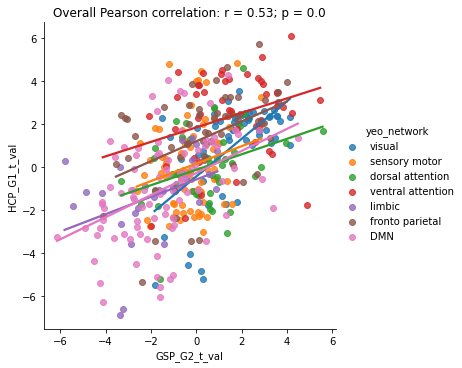

In [149]:
print_plot_corr_networks(df1 = GSP_slm_G2, df2 = HCP_slm_G1, var = 't_val_sex', x_label = 'GSP_G2_t_val', y_label = 'HCP_G1_t_val')

Text(0, 0.5, 'HCP G1')

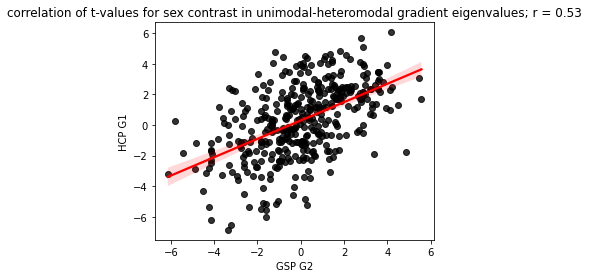

In [203]:
fig, ax = plt.subplots(1, figsize=(5, 4))

sns.regplot(GSP_slm_G2.t_val_sex, HCP_slm_G1.t_val_sex,
            scatter_kws={"color": "black"}, line_kws={"color": "red"})

ax.set_title(f'correlation of t-values for sex contrast in unimodal-heteromodal gradient eigenvalues; r = {round(stats.pearsonr(GSP_slm_G2.t_val_sex, HCP_slm_G1.t_val_sex)[0],2)}')
ax.set_xlabel('GSP G2')
ax.set_ylabel('HCP G1')


#### Spin permutation test

Project t-values (from Schaefer 400 parcellation) to fsaverage5's 20484 vertices

In [28]:
GSP_fs5_tvals_sexdif_G2 = []
HCP_fs5_tvals_sexdif_G1 = []

# iterate over the 20484 vertices in fsaverage5
for i in range(len(schaefer_400_fs5)):
    
    #if schaefer_400_fs5[i] == 'nan'
    if schaefer_400_fs5[i] == 0:
        # append to the lists of fs5_tvals: 0
        GSP_fs5_tvals_sexdif_G2.append(0)
        HCP_fs5_tvals_sexdif_G1.append(0)
        
    # if schaefer_400_fs5 has a value
    else:
        # append to the lists of fs5_tvals: the t value of the corresponding Schaefer parcel (here parcel value [i] - 1 because parcel numbers go from 1-400 instead of 0-399 as required for indexing t_val_sex)
        GSP_fs5_tvals_sexdif_G2.append(GSP_slm_G2.t_val_sex[schaefer_400_fs5[i]-1])
        HCP_fs5_tvals_sexdif_G1.append(HCP_slm_G1.t_val_sex[schaefer_400_fs5[i]-1])

# change the zeros into nan (couldn't nan directly because then it made the array content strings
GSP_fs5_tvals_sexdif_G2[GSP_fs5_tvals_sexdif_G2 == 0] = np.nan
HCP_fs5_tvals_sexdif_G1[HCP_fs5_tvals_sexdif_G1 == 0] = np.nan

# transform list into array
GSP_fs5_tvals_sexdif_G2 = np.asarray(GSP_fs5_tvals_sexdif_G2)
HCP_fs5_tvals_sexdif_G1 = np.asarray(HCP_fs5_tvals_sexdif_G1)

# PROBLEM
values go from 0-400, so there are 401 'categories' -> I assume this means that 0 is a non-category and schaefer parcel labels go from 1-400

!!!!! NEED TO CHECK WHAT THIS NON CATEGORY IS... SEEMS LIKE THERE IS AN ISSUE HERE (I thought it would mean "outside the grid" but I don't think fsaverage is a grid... maybe it's an areas like midline or ventricles which is missing in Schaefer 400)


In [29]:
min(schaefer_400_fs5)

0

In [30]:
max(schaefer_400_fs5)

400

Spin permutation

In [31]:
# Spin permutation testing for two cortical maps (output of spin_test is the p-value and the null distribution)
spin_test_p, spin_test_d = spin_test(GSP_fs5_tvals_sexdif_G2, HCP_fs5_tvals_sexdif_G1, surface_name='fsa5', parcellation_name='aparc', type='pearson', n_rot=1000, null_dist=True)

permutation 100 of 1000
permutation 200 of 1000
permutation 300 of 1000
permutation 400 of 1000
permutation 500 of 1000
permutation 600 of 1000
permutation 700 of 1000
permutation 800 of 1000
permutation 900 of 1000
permutation 1000 of 1000


In [32]:
spin_test_p

0.0

To better interpret statistical significance, we can plot the null distribution of generated correlations (i.e., “spun” or “shuffled” correlations) and overlay the correlation coefficient obtained from the empirical (i.e., real) brain maps.

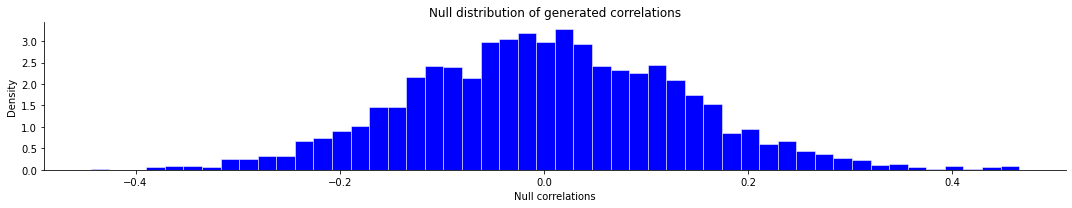

In [34]:
fig, ax = plt.subplots(1, figsize=(15, 3))

ax.hist(spin_test_d, bins=50, density=True, color="blue", edgecolor='white', lw=0.5)
ax.set_xlabel('Null correlations')
ax.set_ylabel('Density')
ax.set_title('Null distribution of generated correlations')
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

    
fig.tight_layout()
plt.show()

TO DO:rvals below (original code)?
also add title

In [ ]:
import matplotlib.pyplot as plt

fig, axs = plt.subplots(1, 4, figsize=(15, 3))

for k, (fn, dd) in enumerate(p_and_d.items()):
    # Define plot colors
    if k <= 1:
        col = '#A8221C'     # red for functional hubs
    else:
        col = '#324F7D'     # blue for structural hubs

    # Plot null distributions
    axs[k].hist(dd[1], bins=50, density=True, color=col, edgecolor='white', lw=0.5)
    axs[k].axvline(rvals[fn], lw=1.5, ls='--', color='k', dashes=(2, 3),
                   label='$r$={:.2f}'.format(rvals[fn]) + '\n$p$={:.3f}'.format(dd[0]))
    axs[k].set_xlabel('Null correlations \n ({})'.format(fn))
    axs[k].set_ylabel('Density')
    axs[k].spines['top'].set_visible(False)
    axs[k].spines['right'].set_visible(False)
    axs[k].legend(loc=1, frameon=False)

fig.tight_layout()
plt.show()

# Equal sex samples in GSP

In [7]:
equal_sex_ratio_resdir = '/data/p_02667/sex_diff_gradients/results/GSP/equal_sex_samples/'

## Comparing results between GSP and HCP samples for 3 fc gradients

In [8]:
## loading aligned gradient arrays

# GSP
GSP_array_aligned_G1 = pd.read_csv(equal_sex_ratio_resdir+'array_aligned_G1.csv')  # visual - somatomotor
GSP_array_aligned_G2 = pd.read_csv(equal_sex_ratio_resdir+'array_aligned_G2.csv')  # unimodal - heteromodal
GSP_array_aligned_G3 = pd.read_csv(equal_sex_ratio_resdir+'array_aligned_G3.csv')  

# HCP
HCP_array_aligned_G1 = pd.read_csv(resdir+'HCP/array_aligned_G1.csv')  # visual - somatomotor
HCP_array_aligned_G2 = pd.read_csv(resdir+'HCP/array_aligned_G2.csv')  # unimodal - heteromodal
HCP_array_aligned_G3 = pd.read_csv(resdir+'HCP/array_aligned_G3.csv')  


# loading SLM (model including sex, age and ICV for sex testing for sex differences) containing R results

# GSP
GSP_slm_G1 = pd.read_csv(equal_sex_ratio_resdir+'R_lm_G1_sex_age_icv_res.csv')  # visual - somatomotor
GSP_slm_G2 = pd.read_csv(equal_sex_ratio_resdir+'R_lm_G2_sex_age_icv_res.csv')  # unimodal - heteromodal
GSP_slm_G3 = pd.read_csv(equal_sex_ratio_resdir+'R_lm_G3_sex_age_icv_res.csv')  

# HCP
HCP_slm_G1 = pd.read_csv(resdir+'HCP/R_lm_G1_sex_age_icv_res.csv')  # unimodal - heteromodal
HCP_slm_G2 = pd.read_csv(resdir+'HCP/R_lm_G2_sex_age_icv_res.csv')  # visual - somatomotor
HCP_slm_G3 = pd.read_csv(resdir+'HCP/R_lm_G3_sex_age_icv_res.csv')  

In [9]:
GSP_array_aligned_G1

,1,2,3,4,5,6,7,8,9,10,...,391,392,393,394,395,396,397,398,399,400
0,-0.082133,-0.066215,-0.080661,-0.084880,-0.077575,-0.076887,-0.062602,-0.073691,-0.015290,0.031513,...,-0.034469,-0.042364,0.006757,0.003033,-0.054271,-0.048465,-0.041827,-0.035801,-0.053990,0.030903
1,-0.030666,-0.053596,-0.053206,-0.048282,-0.082642,-0.068180,-0.035396,-0.051453,-0.084432,-0.051278,...,-0.056285,-0.063770,-0.081328,-0.066138,-0.067382,-0.057770,-0.069832,-0.061462,-0.058846,-0.065523
2,0.025450,-0.041640,-0.058750,-0.006479,-0.049157,-0.039589,0.012992,-0.055401,-0.027367,-0.045053,...,-0.035814,-0.041784,-0.039154,-0.029441,-0.053875,-0.051686,-0.050557,-0.021388,-0.048990,-0.007238
3,-0.023399,-0.039016,-0.019835,-0.075459,-0.077863,-0.056568,-0.013849,0.004952,0.025241,-0.074234,...,-0.048519,-0.044832,-0.027987,-0.025294,-0.069777,-0.068839,-0.050598,-0.036049,-0.064844,-0.041328
4,-0.021171,-0.039445,-0.046569,-0.007720,-0.053457,-0.066678,-0.039309,-0.036640,-0.066544,-0.031893,...,-0.033827,-0.056558,0.006907,-0.046956,-0.059553,-0.056409,-0.036136,-0.013597,-0.057806,-0.034960
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1321,-0.034382,-0.000525,-0.029649,-0.053437,-0.037133,-0.021655,-0.063021,-0.003066,-0.035849,-0.079835,...,-0.064491,-0.026709,-0.039263,-0.031068,-0.067217,-0.055415,-0.060881,-0.060918,-0.069679,-0.010542
1322,-0.091011,-0.043029,-0.104534,-0.107139,-0.095466,-0.085733,-0.043321,-0.034559,-0.092753,-0.084279,...,-0.034066,-0.043631,0.034397,-0.039198,-0.052868,-0.047531,-0.043022,-0.029188,-0.055379,-0.015599
1323,-0.006767,-0.043651,-0.057953,-0.083764,-0.084100,-0.051119,-0.020918,-0.056951,-0.075899,-0.071424,...,-0.045363,-0.055555,-0.060081,-0.078738,-0.054219,-0.047135,-0.052711,-0.031493,-0.052081,-0.002395
1324,-0.032658,-0.067270,-0.063337,-0.054821,-0.048409,-0.024242,-0.062289,-0.034921,-0.027933,-0.048040,...,-0.042740,-0.041016,-0.004929,-0.025418,-0.030720,-0.036519,-0.058757,-0.044947,-0.052560,-0.028018


In [10]:
stats.pearsonr(GSP_slm_G2.t_val_sex, HCP_slm_G1.t_val_sex)

(0.5496274251492854, 5.959788882671919e-33)

/data/u_serio_software/anaconda3/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


Text(0, 0.5, 'HCP G1')

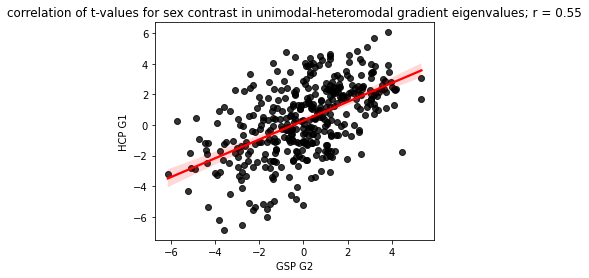

In [11]:
fig, ax = plt.subplots(1, figsize=(5, 4))

sns.regplot(GSP_slm_G2.t_val_sex, HCP_slm_G1.t_val_sex,
            scatter_kws={"color": "black"}, line_kws={"color": "red"})

ax.set_title(f'correlation of t-values for sex contrast in unimodal-heteromodal gradient eigenvalues; r = {round(stats.pearsonr(GSP_slm_G2.t_val_sex, HCP_slm_G1.t_val_sex)[0],2)}')
ax.set_xlabel('GSP G2')
ax.set_ylabel('HCP G1')


### Spin permutation test

https://enigma-toolbox.readthedocs.io/en/latest/pages/08.spintest/index.html

#### Project t-values (from Schaefer 400 parcellation) to fsaverage5's 20484 vertices

In [12]:
# fetch the fsaverage parcellation indicating which schafer parcel (1-400) each of fsaverage5's 20484 vertices belong to
schaefer_400_fs5 = fetch_parcellation("fsaverage5", "schaefer", 400)

In [13]:
GSP_fs5_tvals_sexdif_G2 = []
HCP_fs5_tvals_sexdif_G1 = []

# iterate over the 20484 vertices in fsaverage5
for i in range(len(schaefer_400_fs5)):
    
    #if schaefer_400_fs5[i] == 'nan'
    if schaefer_400_fs5[i] == 0:
        # append to the lists of fs5_tvals: 0
        GSP_fs5_tvals_sexdif_G2.append(0)
        HCP_fs5_tvals_sexdif_G1.append(0)
        
    # if schaefer_400_fs5 has a value
    else:
        # append to the lists of fs5_tvals: the t value of the corresponding Schaefer parcel (here parcel value [i] - 1 because parcel numbers go from 1-400 instead of 0-399 as required for indexing t_val_sex)
        GSP_fs5_tvals_sexdif_G2.append(GSP_slm_G2.t_val_sex[schaefer_400_fs5[i]-1])
        HCP_fs5_tvals_sexdif_G1.append(HCP_slm_G1.t_val_sex[schaefer_400_fs5[i]-1])

# change the zeros into nan (couldn't nan directly because then it made the array content strings
GSP_fs5_tvals_sexdif_G2[GSP_fs5_tvals_sexdif_G2 == 0] = np.nan
HCP_fs5_tvals_sexdif_G1[HCP_fs5_tvals_sexdif_G1 == 0] = np.nan

# transform list into array
GSP_fs5_tvals_sexdif_G2 = np.asarray(GSP_fs5_tvals_sexdif_G2)
HCP_fs5_tvals_sexdif_G1 = np.asarray(HCP_fs5_tvals_sexdif_G1)

# PROBLEM
values go from 0-400, so there are 401 'categories' -> I assume this means that 0 is a non-category and schaefer parcel labels go from 1-400

!!!!! NEED TO CHECK WHAT THIS NON CATEGORY IS... SEEMS LIKE THERE IS AN ISSUE HERE (I thought it would mean "outside the grid" but I don't think fsaverage is a grid... maybe it's an areas like midline or ventricles which is missing in Schaefer 400)


In [14]:
min(schaefer_400_fs5)

0

In [15]:
max(schaefer_400_fs5)

400

In [16]:
# Spin permutation testing for two cortical maps (output of spin_test is the p-value and the null distribution)
spin_test_p, spin_test_d = spin_test(GSP_fs5_tvals_sexdif_G2, HCP_fs5_tvals_sexdif_G1, surface_name='fsa5', parcellation_name='aparc', type='pearson', n_rot=1000, null_dist=True)

permutation 100 of 1000
permutation 200 of 1000
permutation 300 of 1000
permutation 400 of 1000
permutation 500 of 1000
permutation 600 of 1000
permutation 700 of 1000
permutation 800 of 1000
permutation 900 of 1000
permutation 1000 of 1000


In [17]:
spin_test_p

0.0

In [18]:
spin_test_d

array([ 0.0613521 ,  0.19096881,  0.11052274, ...,  0.01444785,
       -0.13502071,  0.02716053])

To better interpret statistical significance, we can plot the null distribution of generated correlations (i.e., “spun” or “shuffled” correlations) and overlay the correlation coefficient obtained from the empirical (i.e., real) brain maps.

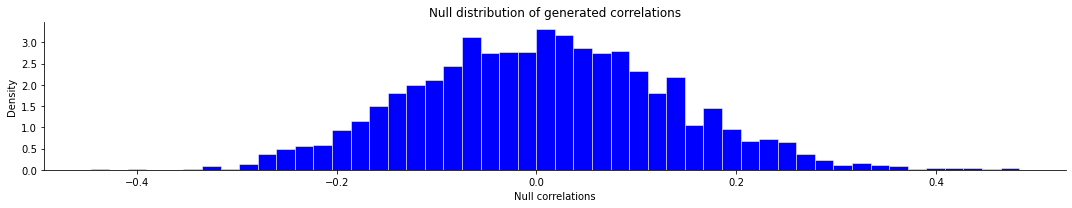

In [19]:
fig, ax = plt.subplots(1, figsize=(15, 3))

ax.hist(spin_test_d, bins=50, density=True, color="blue", edgecolor='white', lw=0.5)
ax.set_xlabel('Null correlations')
ax.set_ylabel('Density')
ax.set_title('Null distribution of generated correlations')
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

    
fig.tight_layout()
plt.show()

# old to delete (changing to nan)

In [42]:
GSP_fs5_tvals_sexdif_G2 = []
HCP_fs5_tvals_sexdif_G1 = []

# iterate over the 20484 vertices in fsaverage5
for i in range(len(schaefer_400_fs5)):
    
    #if schaefer_400_fs5[i] == 'nan'
    if isnan(schaefer_400_fs5[i]):
        # append to the lists of fs5_tvals: 0
        GSP_fs5_tvals_sexdif_G2.append(0)
        HCP_fs5_tvals_sexdif_G1.append(0)
        
    # if schaefer_400_fs5 has a value
    else:
        # append to the lists of fs5_tvals: the t value of the corresponding Schaefer parcel (here parcel value [i] - 1 because parcel numbers go from 1-400 instead of 0-399 as required for indexing t_val_sex)
        GSP_fs5_tvals_sexdif_G2.append(GSP_slm_G2.t_val_sex[schaefer_400_fs5[i]-1])
        HCP_fs5_tvals_sexdif_G1.append(HCP_slm_G1.t_val_sex[schaefer_400_fs5[i]-1])

# change the zeros into nan (couldn't nan directly because then it made the array content strings
GSP_fs5_tvals_sexdif_G2[GSP_fs5_tvals_sexdif_G2 == 0] = np.nan
HCP_fs5_tvals_sexdif_G1[HCP_fs5_tvals_sexdif_G1 == 0] = np.nan

# transform list into array
GSP_fs5_tvals_sexdif_G2 = np.asarray(GSP_fs5_tvals_sexdif_G2)
HCP_fs5_tvals_sexdif_G1 = np.asarray(HCP_fs5_tvals_sexdif_G1)